In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
from torchvision import transforms
from PIL import Image

import boundary
from boundary.attributions import PT_IntegratedGradient
from boundary import BA_pytorch

from trulens.visualizations import Visualizer, HeatmapVisualizer, MaskVisualizer

import os
os.environ['TRULENS_BACKEND'] = 'pytorch'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Load an example image

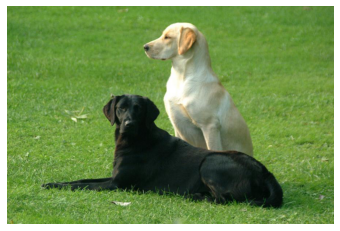

In [2]:
from PIL import Image
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

img = pil_loader("dogs.jpg")
plt.imshow(img)
plt.axis("off")
plt.show()

## Transform to Pytorch Tensors

In [3]:
# We will use torch vision models. The following is the standard preprocessing.
data_min = np.min((0 - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225]))
data_max = np.max((1 - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225]))
transform=transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

X = [img]
for i in range(len(X)):
    X[i] = transform(X[i]).unsqueeze(0)
X = torch.cat(X, dim=0)
print(f"X's shape is {X.size()}")

X's shape is torch.Size([1, 3, 224, 224])


## Load a Pytorch Model

In [4]:
model = models.resnet50(pretrained=True)

In [5]:
model = model.cuda()
model = model.eval()
_, pred = torch.max(model(X.cuda()).detach().cpu().data, 1)
print("Prediction: ", pred)
# 208: 'Labrador retriever'

Prediction:  tensor([208])


In [6]:
n_classes = 1000
numpy_data_x = X.numpy()
numpy_data_y = pred.numpy()
labels_onehot = np.squeeze(np.eye(n_classes)[numpy_data_y.reshape(-1)])[None,:]

## Compute Attributions

In [7]:
#Wrap the Integrated Gradient with BA_pytorch Wrapper
big = BA_pytorch('BIG', use_boundary=True)

In [24]:
parameters = boundary.PARAMETERS
parameters['n_steps'] = 50
print(">>> Parameters of the model ....")
for k in parameters.keys():
    print(f"{k}: {parameters[k]}")
print("\n")
pipeline = boundary.PIPELINE
# If you want to modify the default parameters
pipeline['pgd_eps'] = [36/255., 64/255., 0.3, 0.5, 0.7, 0.9, 1.0, 1.1, 1.3]
pipeline['pgd_max_steps'] = 100
pipeline['methods'] = 'PGDs'

print(">>> Parameters of Pipeline ....")
for k in pipeline.keys():
    print(f"{k}: {pipeline[k]}")

>>> Parameters of the model ....
batch_size: 32
data_min: -2.1179039301310043
data_max: 2.6399999999999997
device: cuda:0
n_steps: 50
stdevs: 0.15


>>> Parameters of Pipeline ....
methods: PGDs
norm: l2
pgd_eps: [0.1411764705882353, 0.25098039215686274, 0.3, 0.5, 0.7, 0.9, 1.0, 1.1, 1.3]
pgd_step_size: None
pgd_max_steps: 100
cw_eps: 1.0
cw_step_size: 0.01
cw_max_steps: 100


In [25]:
attr = big.attribute(model,
                     numpy_data_x,
                     labels_onehot,
                     pipline=pipeline,
                     return_dis=False,
                     **parameters)

>>> Start PGD Attack <<<


  0%|          | 0/1 [00:00<?, ?it/s]

>>> Attacking with EPS=0.1411764705882353 (norm=l2), Success Rate=0.0 <<<
>>> Attacking with EPS=0.25098039215686274 (norm=l2), Success Rate=0.0 <<<
>>> Attacking with EPS=0.3 (norm=l2), Success Rate=0.0 <<<
>>> Attacking with EPS=0.5 (norm=l2), Success Rate=0.0 <<<
>>> Attacking with EPS=0.7 (norm=l2), Success Rate=1.0 <<<
>>> Attacking with EPS=0.9 (norm=l2), Success Rate=1.0 <<<
>>> Attacking with EPS=1.0 (norm=l2), Success Rate=1.0 <<<
>>> Attacking with EPS=1.1 (norm=l2), Success Rate=1.0 <<<


  0%|          | 0/1 [00:00<?, ?it/s]

>>> Attacking with EPS=1.3 (norm=l2), Success Rate=1.0 <<<
boundary points: f(1, 3, 224, 224)


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


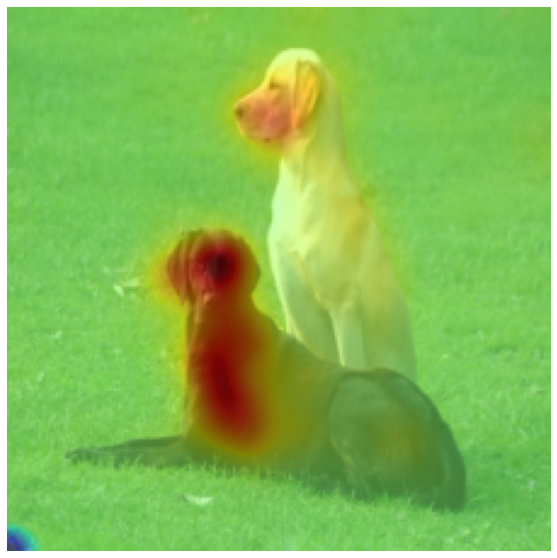

In [26]:
mask_viz = HeatmapVisualizer(blur=7, normalization_type="signed_max")
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

img = numpy_data_x.copy()
img[:, 0] = img[:, 0]*std[0] + mean[0]
img[:, 1] = img[:, 1]*std[1] + mean[1]
img[:, 2] = img[:, 2]*std[2] + mean[2]

fig = plt.figure(figsize=(10,10))
_ = mask_viz(attr, img, overlay_opacity=0.5, fig=fig, return_tiled=False) 